In [1]:
import warnings
warnings.filterwarnings("ignore")
import fhmm_support as fhm
from hmmlearn import hmm
import numpy as np
np.random.seed(23)
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import OrderedDict
import time
#import ipdb

In [2]:
import sys
sys.version

'2.7.13 |Continuum Analytics, Inc.| (default, Dec 20 2016, 23:05:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

In [3]:
#!jupyter nbconvert --to script fhmm_call_from_R.ipynb

[NbConvertApp] Converting notebook fhmm_call_from_R.ipynb to script
[NbConvertApp] Writing 2177 bytes to fhmm_call_from_R.py


In [4]:
# List all houses in a directory
dir = "/Volumes/MacintoshHD2/Users/haroonr/Detailed_datasets/Dataport/mix_homes/default_3months/"
houses = [f for f in os.listdir(dir)]
df = pd.read_csv(dir+houses[0],index_col='localminute')
df.index = pd.to_datetime(df.index)


In [5]:
res = df.sum(axis=0)
high_energy_apps = res.nlargest(6).keys()
df_new = df[high_energy_apps]

In [6]:
def divide_dataset_in_appliances(df):
    agg_meter = df['use']
    meters = df.columns
    #import ipdb;ipdb.set_trace()
    meters = meters.drop('use')
    sub_meters = df[meters]
    return (agg_meter,sub_meters)

In [7]:
train_dset = df_new.truncate(before="2014-06-01", after="2014-06-10 23:59:59")
test_dset = df_new.truncate(before="2014-06-11", after="2014-06-15 23:59:59")

In [8]:
train_agg_meter,train_sub_meters = divide_dataset_in_appliances(train_dset)
test_agg_meter,test_sub_meters = divide_dataset_in_appliances(test_dset)

In [9]:
# train model for each applaince
model = OrderedDict()
appliances = train_sub_meters.columns
for appliance in appliances:
   # print appliance;
    model[appliance] =  hmm.GaussianHMM(n_components=2,covariance_type="full")
    temp =  train_sub_meters[appliance].values.reshape(len(train_sub_meters[appliance]),1)
    model[appliance].fit(temp)
    

In [12]:
# sort all the parameters and update new models with these 
new_learnt_models= OrderedDict()
for appliance in model:
    #print appliance;
    startprob, means, covars, transmat = fhm.sort_learnt_parameters(model[appliance].startprob_, model[appliance].means_, model[appliance].covars_ , model[appliance].transmat_) 
    new_learnt_models[appliance]=hmm.GaussianHMM(startprob.size, "full", startprob, transmat)
    new_learnt_models[appliance].means_ = means
    new_learnt_models[appliance].covars_ = covars

In [14]:
reload(fhm)

<module 'fhmm_support' from 'fhmm_support.pyc'>

In [15]:
# create aggregate model
learnt_model_combined = fhm.create_combined_hmm(new_learnt_models)

p0
p1
p2
[(0.0, 71.23399508201537, 0.0, 0.0, 0.0), (0.0, 71.23399508201537, 0.0, 0.0, 297.44641794977287), (0.0, 71.23399508201537, 0.0, 104.62110424768423, 0.0), (0.0, 71.23399508201537, 0.0, 104.62110424768423, 297.44641794977287), (0.0, 71.23399508201537, 3537.213083311497, 0.0, 0.0), (0.0, 71.23399508201537, 3537.213083311497, 0.0, 297.44641794977287), (0.0, 71.23399508201537, 3537.213083311497, 104.62110424768423, 0.0), (0.0, 71.23399508201537, 3537.213083311497, 104.62110424768423, 297.44641794977287), (0.0, 296.80693768674047, 0.0, 0.0, 0.0), (0.0, 296.80693768674047, 0.0, 0.0, 297.44641794977287), (0.0, 296.80693768674047, 0.0, 104.62110424768423, 0.0), (0.0, 296.80693768674047, 0.0, 104.62110424768423, 297.44641794977287), (0.0, 296.80693768674047, 3537.213083311497, 0.0, 0.0), (0.0, 296.80693768674047, 3537.213083311497, 0.0, 297.44641794977287), (0.0, 296.80693768674047, 3537.213083311497, 104.62110424768423, 0.0), (0.0, 296.80693768674047, 3537.213083311497, 104.62110424768

In [16]:
temp1 = test_agg_meter.values.reshape(len(test_agg_meter),1)
start_time = time.time()
new_learnt_states = learnt_model_combined.predict(temp1)
print('time taken %f seconds' %(time.time() - start_time))

NotFittedError: This GaussianHMM instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [18]:
temp_means = OrderedDict()
for app in model:
    temp_means[app] = new_learnt_models[app].means_
[decoded_states, decoded_power] = fhm.decode_hmm(len(new_learnt_states), temp_means, [appliance for appliance in model], new_learnt_states)

In [31]:
decoded_power = pd.DataFrame(decoded_power)

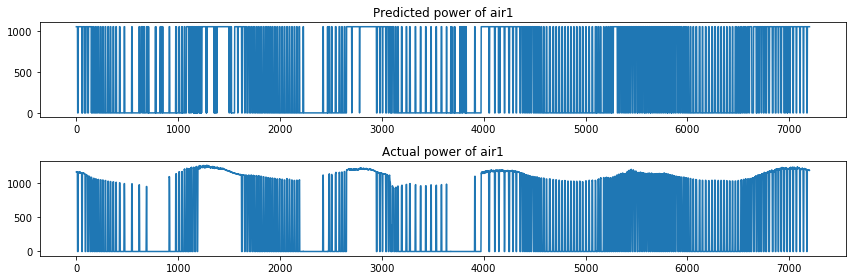

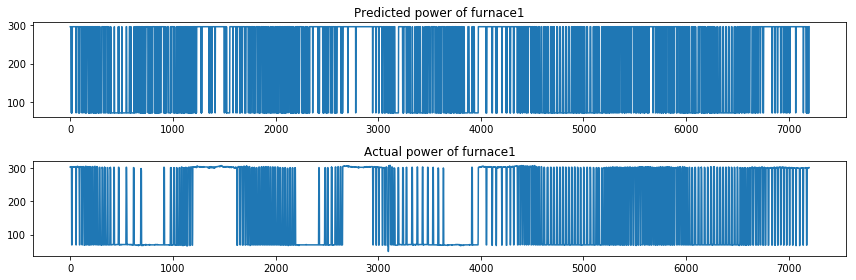

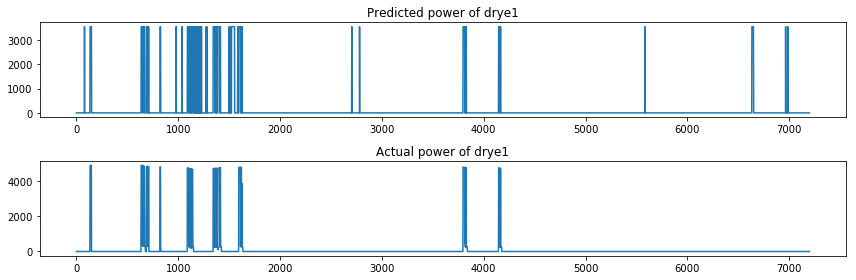

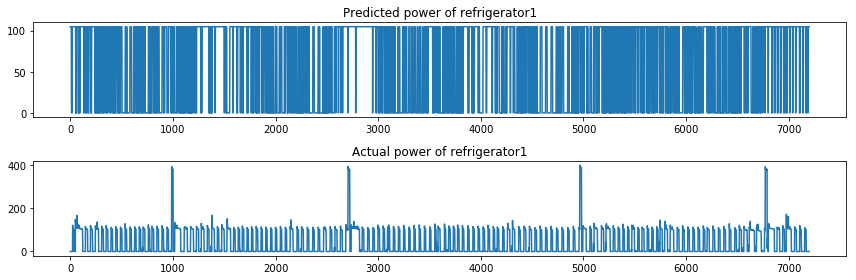

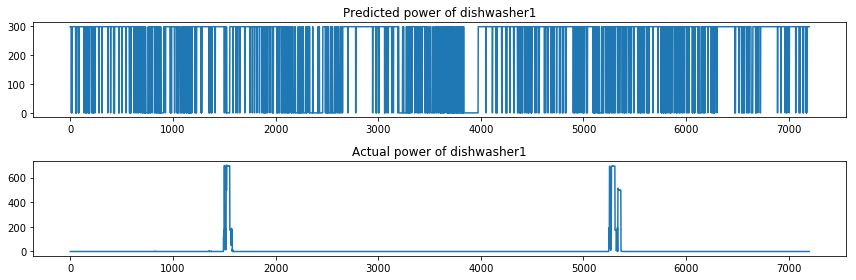

In [13]:
for appliance in model:
    plt.figure(figsize=(12,4))
    plt.subplot(2,1,1)
    plt.plot(decoded_power[appliance])
    plt.title("Predicted power of %s" %appliance)
    plt.subplot(2,1,2)
    #from IPython.core.debugger import Tracer
    #Tracer()()
    plt.plot(test_sub_meters[appliance].values)
    plt.title("Actual power of %s" %appliance)
    plt.tight_layout()

In [77]:
def compute_rmse(gt,pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for app in gt.columns:
        rms_error[app] =  np.sqrt(mean_squared_error(gt[app],pred[app]))
    return pd.Series(rms_error)

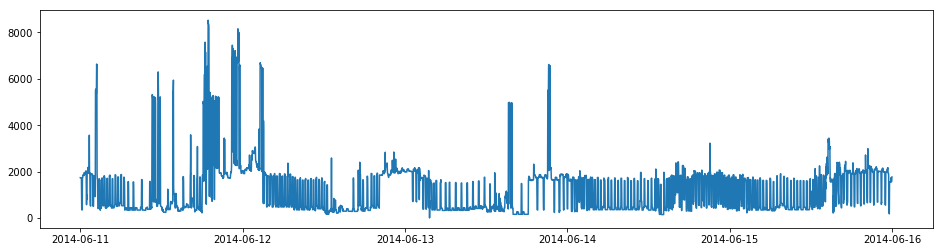

In [22]:
plt.figure(figsize=(16,4))
plt.subplot(111)
plt.plot(test_agg_meter)

In [78]:
compute_rmse(test_sub_meters,decoded_power)

air1             231.145140
dishwasher1      255.889090
drye1            446.736665
furnace1         132.444224
refrigerator1     72.617613
dtype: float64